<a href="https://colab.research.google.com/github/Min-ju-Kim/AIFFEL_Going-Deeper/blob/main/5.%20Segmentation/%5BGD_10%5DSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Going Deeper 10. Segmentation



<p align='middle'><img src='https://d3s0tskafalll9.cloudfront.net/media/images/68747470733a2f2f.max-800x600.png' width='450'></p>

<p align='middle'><img src='https://d3s0tskafalll9.cloudfront.net/media/original_images/result.gif' width='450'></p>


### Table of Contents

### 1. Experiment Environment Set-up
* 1.1 Load Dataset
* 1.2 Set Up Albumentation
* 1.3 Import Libraries

### 2. Data Augmentation

### 3. Data Generator
* 3.1 Class KittiGenerator
* 3.2 Train, Test Generator

### 4. U-Net
* 4.1 Building U-Net Model
* 4.2 U-Net Training
* 4.3 U-Net Results

### 5. U-Net++
* 5.1 Building U-Net++ Model
* 5.2 BCE-Dice Loss
* 5.3 U-Net++ Training
* 5.4 U-Net++ Results

****

### 1. Experiment Environment Set-up

### 1.1 Load Dataset

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Going Deeper/Data

# 데이터 다운로드
!wget https://gd10-data.s3.ap-northeast-2.amazonaws.com/data.zip

# 데이터 압축풀기
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/Going Deeper/Data/data.zip'

/content/drive/MyDrive/Colab Notebooks/Going Deeper/Data
--2022-04-11 01:39:10--  https://gd10-data.s3.ap-northeast-2.amazonaws.com/data.zip
Resolving gd10-data.s3.ap-northeast-2.amazonaws.com (gd10-data.s3.ap-northeast-2.amazonaws.com)... 52.219.56.7
Connecting to gd10-data.s3.ap-northeast-2.amazonaws.com (gd10-data.s3.ap-northeast-2.amazonaws.com)|52.219.56.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680475564 (649M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 648.95M  41.4MB/s    in 17s     

2022-04-11 01:39:27 (38.0 MB/s) - ‘data.zip’ saved [680475564/680475564]

replace data/testing/image_2/000140_10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

* 지금까지 보던 라벨 데이터와 다르게 세크멘테이션 데이터는 이미지 형태의 라벨로 되어있다.
* [라벨](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py) 참고

### 1.2 Set Up Albumentation

In [ ]:
# albumentation 라이브러리 설치
!pip list | grep albumentations

albumentations                0.1.12


### 1.3 Import Libraries

In [ ]:
# 필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt

# scikit-image(skimage) : 이미지 처리하기 위한 파이썬 라이브러리
from skimage.io import imread
from skimage.transform import resize
from glob import glob  # 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환

# 와일드 임포트(wild import)
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

# albumentations 라이브러리
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

### 2. Data Augmentation

In [ ]:
# 모델을 학습시킬 수 있는 데이터 로더(data loader)만들기
# 로더는 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱 해야한다.
# Albumentation의 사용법 알아보기
# Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용예

def build_augmentation(is_train=True):
  if is_train:  # 훈련용 데이터일 경우

    # Compose()는 여러가지 방법을 조합할 수 있다. 
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행 
                Resize(
                    width=224,
                    height=224
                    )
                ])

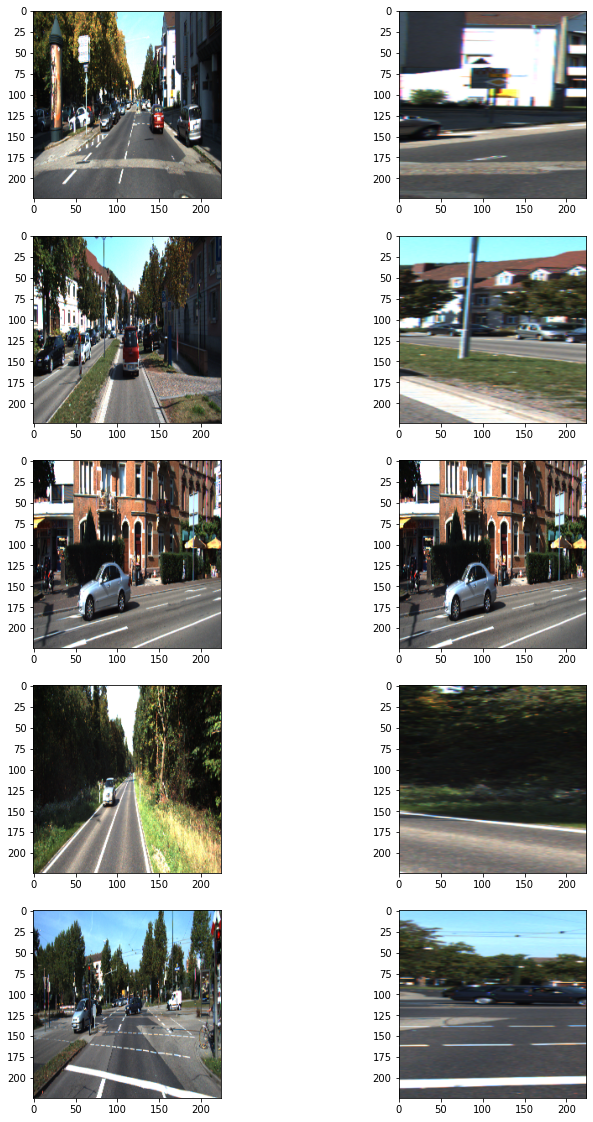

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/Going Deeper/Data/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해본다. 
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)  # resize만 적용, '**' : 딕셔너리가 풀어진 형태로 삽입된다.
    processed = augmentation_train(**image_data)  # augmentation까지 적용
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

### 3. Data Generator

### 3.1. Class KittiGenerator

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받는다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용한다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path : dataset의 directory path
    batch_size : batch_size
    img_size : preprocess에 사용할 입력이미지의 크기
    output_size : ground_truth를 만들어주기 위한 크기
    is_train : 이 Generator가 학습용인지 테스트용인지 구분
    augmentation : 적용하길 원하는 augmentation 함수를 인자로 받는다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인한다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야한다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)  # assert는 뒤의 조건이 True가 아니면 AssertError를 발생
    data = [ _ for _ in zip(input_images, label_images)]  # 리스트 형태로 data 변수에 저장

    if self.is_train:
      return data[:-30]  # train이면 뒤에서 30개 남기고 가져온다.
    return data[-30:]  # train이 아닌 경우 뒤에서 30개 가져온다. 
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환한다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만든다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label이다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ] 
    inputs = np.zeros([self.batch_size, *self.img_size]) 
    outputs = np.zeros([self.batch_size, *self.output_size]) 
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1  # 라벨이 도로(7)인 경우 넘파이 배열로 변환
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]  ###### ?? 얘는 왜 안나눌까?
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

### 3.2 Train, Test Generator

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### 4. U-Net

<p align='middle'><img src='https://d3s0tskafalll9.cloudfront.net/media/images/u-net_1kfpgqE.max-800x600.png' width='450'></p>

### 4.1 Building U-Net Model

In [ ]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  # 없어도 무방한 레이어로 적용해준 패딩에 대한 보정역할    
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

### 4.2 U-Net Training

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Going Deeper/Model/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장한다.

Epoch 1/100
11/11 [==============================] - 18s 384ms/step - loss: 0.6746 - val_loss: 0.6537
Epoch 2/100
11/11 [==============================] - 4s 325ms/step - loss: 0.3629 - val_loss: 0.0342
Epoch 3/100
11/11 [==============================] - 4s 326ms/step - loss: 0.0363 - val_loss: 0.0359
Epoch 4/100
11/11 [==============================] - 4s 325ms/step - loss: 0.0287 - val_loss: 0.0341
Epoch 5/100
11/11 [==============================] - 4s 325ms/step - loss: 0.0284 - val_loss: 0.0308
Epoch 6/100
11/11 [==============================] - 4s 330ms/step - loss: 0.0268 - val_loss: 0.0301
Epoch 7/100
11/11 [==============================] - 4s 326ms/step - loss: 0.0306 - val_loss: 0.0332
Epoch 8/100
11/11 [==============================] - 4s 328ms/step - loss: 0.0271 - val_loss: 0.0246
Epoch 9/100
11/11 [==============================] - 4s 325ms/step - loss: 0.0240 - val_loss: 0.0241
Epoch 10/100
11/11 [==============================] - 4s 325ms/step - loss: 0.0217 - val_l

### 4.3 U-Net Results

### 4.3.1 Visualization

In [ ]:
# 학습한 모델 불러오기
model = tf.keras.models.load_model(model_path)

In [ ]:
# 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 오버레이(overray)
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data) 
     output = model(np.expand_dims(processed["image"]/255,axis=0))  ###### ?? 차원을 늘렸다 줄이는 이유??
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)  # 배경이미지와 belnd 시켜준다.
     output.show()
     return output 

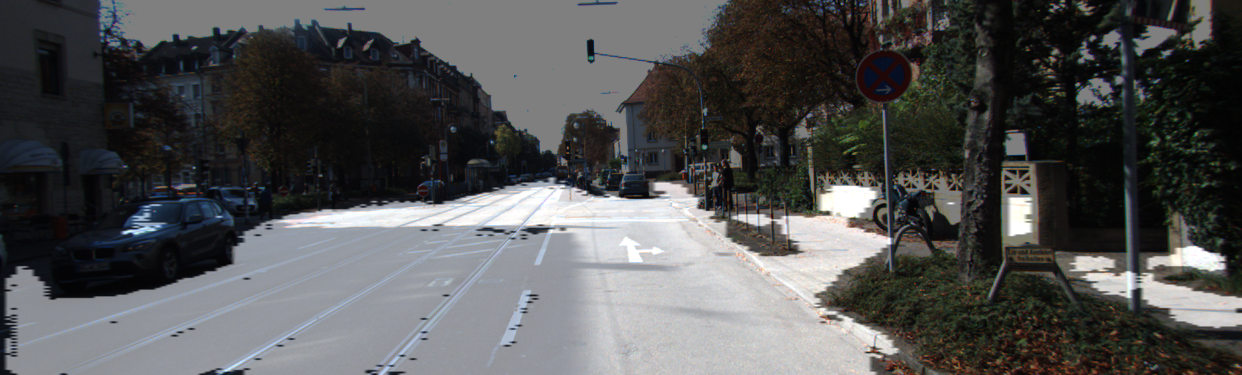

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해본다.
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### 4.3.2 IoU

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해본다.
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.822695


0.8226950354609929

### 5. U-Net++

<p align = 'middle'><img src = 'https://drive.google.com/uc?export=view&id=1xCOsk_chrkOLyUWDbFRycg-OrWaBzg02' width='500'></p>

<p align = 'middle'><img src = 'https://d3s0tskafalll9.cloudfront.net/media/images/GC-5-P-UNPP.max-800x600.png' width = '500'></p>

### 5.1 Building U-Net++ Model

In [ ]:
# U-Net Plus Plus

def build_UPP_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  # x0_0
  conv0_0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv0_0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_0_1)
  drop1_2 = Dropout(0.5)(conv0_0_2)

  # x1_0
  pool1 = MaxPooling2D(pool_size=(2, 2))(drop1_2)
  conv1_0_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv1_0_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_0_1)
  drop2_2 = Dropout(0.5)(conv1_0_2)

  # x0_1
  up1 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop2_2)
  merge1 = concatenate([drop1_2,up1], axis = 3)
  conv0_1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1)
  conv0_1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1_1)
  drop3_2 = Dropout(0.5)(conv0_1_2)  # output return

  # x2_0
  pool2 = MaxPooling2D(pool_size=(2, 2))(drop2_2)
  conv2_0_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv2_0_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_0_1)
  drop4_2 = Dropout(0.5)(conv2_0_2)

  # x1_1
  up2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop4_2)
  merge2 = concatenate([drop2_2,up2], axis = 3)
  conv1_1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2)
  conv1_1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1_1)
  drop5_2 = Dropout(0.5)(conv1_1_2)  

  # x0_2
  up3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5_2)
  merge3 = concatenate([drop1_2,drop3_2,up3], axis = 3)
  conv0_2_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3)
  conv0_2_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2_1)
  drop6_2 = Dropout(0.5)(conv0_2_2)  # output return

  # x3_0
  pool3 = MaxPooling2D(pool_size=(2, 2))(drop4_2)
  conv3_0_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3) 
  conv3_0_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_0_1)
  drop7_2 = Dropout(0.5)(conv3_0_2)

  # x2_1
  up4 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop7_2)
  merge4 = concatenate([drop4_2,up4], axis = 3)
  conv2_1_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge4)
  conv2_1_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1_1)
  drop8_2 = Dropout(0.5)(conv2_1_2) 

  # x1_2
  up5 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop8_2)
  merge5 = concatenate([drop5_2,drop2_2,up5], axis = 3)
  conv1_2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge5)
  conv1_2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2_1)
  drop9_2 = Dropout(0.5)(conv1_2_2) 

  # x0_3
  up6 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop9_2)
  merge6 = concatenate([drop6_2,drop1_2,up6], axis = 3)
  conv0_3_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv0_3_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3_1)
  drop10_2 = Dropout(0.5)(conv0_3_2)  # output return

  # x4_0
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop7_2)
  conv4_0_1 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)
  conv4_0_2 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_0_1)
  drop11_2 = Dropout(0.5)(conv4_0_2)

  # x3_1
  up7 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop11_2)
  merge7 = concatenate([drop7_2,up7], axis = 3)
  conv3_1_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv3_1_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1_1)
  drop12_2 = Dropout(0.5)(conv3_1_2) 

  # x2_2
  up8 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop12_2)
  merge8 = concatenate([drop8_2,drop4_2,up8], axis = 3)
  conv2_2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv2_2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2_1)
  drop13_2 = Dropout(0.5)(conv2_2_2) 

  # x1_3
  up9 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop13_2)
  merge9 = concatenate([drop9_2,drop2_2,drop5_2,up9], axis = 3)
  conv1_3_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv1_3_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3_1)
  drop14_2 = Dropout(0.5)(conv1_3_2) 

  # x0_4
  up10 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop14_2)
  merge10 = concatenate([drop1_2,drop3_2,drop6_2,drop10_2,up10], axis = 3)
  conv0_4_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge10)
  conv0_4_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4_1)
  drop15_2 = Dropout(0.5)(conv0_4_2)  # output return


  nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', name='output_1')(drop3_2)  # x0_1
  nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_2')(drop6_2)  # x0_2
  nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', name='output_3')(drop10_2)  # x0_3
  nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', name='output_4')(drop15_2)  # x0_4

  output = (nestnet_output_1 + nestnet_output_2 + nestnet_output_3 + nestnet_output_4) / 4

  model = Model(inputs = inputs, outputs=output)
  return model

<p align='middle'><img src='https://d3s0tskafalll9.cloudfront.net/media/images/gc-5v2-p-4-2.max-800x600.png' width='500'></p>

### 5.2 BCE-Dice Loss

In [ ]:
import keras.backend as K

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

### 5.3 U-Net++ Training

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Going Deeper/Model/seg_model_uppnet2.h5'

model = build_UPP_model()
model.compile(optimizer = Adam(1e-4), loss = bce_dice_loss, metrics=["binary_crossentropy", dice_coef])
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장한다.

Epoch 1/100
11/11 [==============================] - 14s 942ms/step - loss: 0.3080 - binary_crossentropy: 0.7046 - dice_coef: 0.0443 - val_loss: 0.3061 - val_binary_crossentropy: 0.6954 - val_dice_coef: 0.0416
Epoch 2/100
11/11 [==============================] - 10s 872ms/step - loss: 0.3046 - binary_crossentropy: 0.6980 - dice_coef: 0.0444 - val_loss: 0.2987 - val_binary_crossentropy: 0.6798 - val_dice_coef: 0.0412
Epoch 3/100
11/11 [==============================] - 10s 873ms/step - loss: 0.2984 - binary_crossentropy: 0.6681 - dice_coef: 0.0356 - val_loss: 0.2668 - val_binary_crossentropy: 0.6242 - val_dice_coef: 0.0453
Epoch 4/100
11/11 [==============================] - 10s 872ms/step - loss: 0.2161 - binary_crossentropy: 0.5197 - dice_coef: 0.0438 - val_loss: 0.1258 - val_binary_crossentropy: 0.3873 - val_dice_coef: 0.0678
Epoch 5/100
11/11 [==============================] - 10s 873ms/step - loss: 0.0289 - binary_crossentropy: 0.2602 - dice_coef: 0.1013 - val_loss: -0.0599 - val_b

### 5.4 U-Net++ Results

### 5.4.1 Visualization

In [ ]:
# 학습한 모델 불러오기
model = tf.keras.models.load_model(model_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef})

In [ ]:
# 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 오버레이(overray)
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data) 
     output = model(np.expand_dims(processed["image"]/255,axis=0))  ###### ?? 차원을 늘렸다 줄이는 이유??
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)  # 배경이미지와 belnd 시켜준다.
     output.show()
     return output 

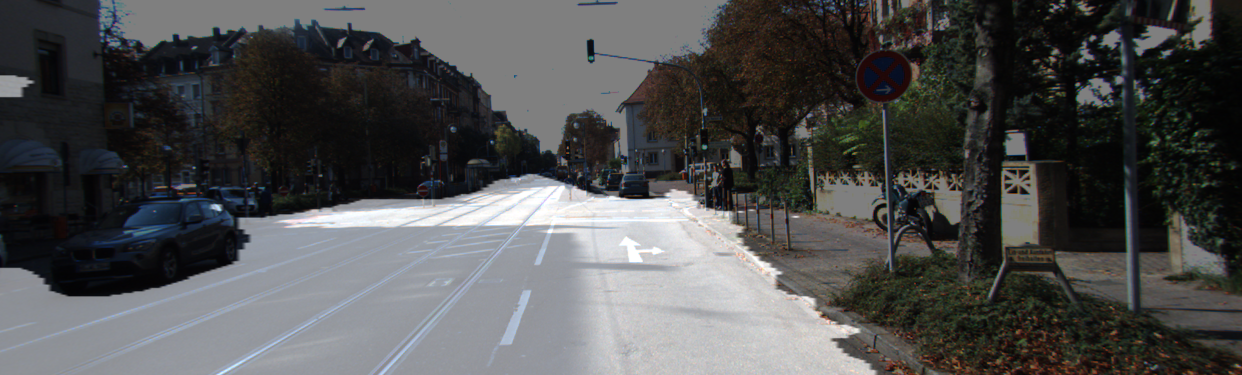

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해본다.
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### 5.4.2 IoU

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해본다.
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.921766


0.9217664200851827

### 6. Conclusion

### 6.1 Visualization

* 사진 결과를 봤을 때 U-Net의 경우 도로가 아닌 부분까지 인식하고 있으며, U-Net++도 마찬가지이나 U-Net보다는 더 나은 것 같아 보인다.

### 6.2 IoU

|U-Net|U-Net++|
| :--: | :--: |
| 0.822695 | 0.921766 |

* IoU를 두고 봤을 때 U-Net++가 성능이 더 좋은 것으로 나타난다.

### 7. Retrospection

### 7.1 What was difficult

* U-Net++ 모델 구현 시 block을 만들어서 시도해보고 싶었으나, 너무 어려워서 다음에 시도해보기로...😥

### 7.2 What I found out

1. `numpy.expand_dims(a, axis)`
* Expand the shape of an array.
* Insert a new axis that will appear at the axis position in the expanded array shape.
* `a`(array_like) : Input array.
* `axis`(int or tuple of ints) : Position in the expanded axes where the new axis (or axes) is placed.

2. `numpy.squeeze(a, axis=None)`
* Remove axes of length one from a.
* `a`(array_like) : Input array.
* `axis`(None or int or tuple of ints, optional) : Selects a subset of the entries of length one in the shape. If an axis is selected with shape entry greater than one, an error is raised.

3. `Image.fromarray()`
* 배열 객체를 입력으로 받아 배열 객체에서 만든 이미지 객체를 반환한다.

4. `zfill()`
* 문자열 앞을 0으로 채운다.
```python
for x in range(3):
    print( str(x).zfill(4) )
>>> 0000
>>> 0001
>>> 0002
```

### 7.3 What I want to know more about

* 모델 구현 시 block을 사용해 구현해보기

### 7.4 Self-Resolution

* U-Net++ 말고 U-Net3+ 구현을 해보고 싶다.